In [1]:
%pylab inline
from scipy.stats import gaussian_kde
import tensorflow as tf
from crystal import crystal
from tensorflow.contrib.opt import ScipyOptimizerInterface
import pandas as pd
import simulate
from tensorflow.python.client import device_lib
import re

print("Version: {}".format(tf.__version__))
print(device_lib.list_local_devices())


Populating the interactive namespace from numpy and matplotlib


/home/kevin/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Version: 1.9.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4102599525879773750
]


In [58]:
reflectionFN = 'test/reflections.csv.bz2'
imagedataFN = 'test/imagedata.csv.bz2'

SNR_CUTOFF = 1.5 #Minimum I/SIGMA(I)

I = pd.read_csv(reflectionFN)
I = I[I['IOBS']/I['SIGMA(IOBS)'] > SNR_CUTOFF]
I = crystal(I.set_index(['H', 'K', 'L']))
I.spacegroup = 4
I.populate_merged_hkls()

M = pd.read_csv(imagedataFN).set_index('Image#')
M['SERIES'] = M['file_name'].apply(lambda x: 'off' if 'off' in x else 'on') + M['file_name'].apply(lambda x: x.split('/')[-1].split('_')[0])
M['RUN'] = M['file_name'].apply(lambda x:int(re.search(r'(?<=r)[0-9]*', x).group()))
M['PHINUMBER'] = M['file_name'].apply(lambda x : int(re.search(r'(?<=_)[0-9]+(?=.tiff)', x).group()))

I = I.reset_index().merge(M.reset_index(), on='Image#')

(3, 1661637)


In [59]:
print("Number of reflection observations: {}".format(len(I)))
print("Multiplicity: {}".format(len(I)/len(I.groupby(['H', 'K', 'L']))))

#This removes reflections which were not observed in the 'on' and 'off' datasets at a given rotation
I = I.groupby(['H', 'K', 'L', 'RUN', 'PHINUMBER']).filter(lambda x: x.SERIES.str.contains('on').max() and x.SERIES.str.contains('off').max())

gammaobs = len(I.groupby(['H', 'K', 'L', 'RUN', 'PHINUMBER']))
gammamult = gammaobs / len(I.groupby(['H', 'K', 'L']))
print("Number of gamma observations: {}".format(gammaobs))
print("Multiplicity: {}".format(gammamult))

Number of reflection observations: 1661637
Multiplicity: 19.85039661681082
Number of gamma observations: 249702
Multiplicity: 4.496461563394738


In [60]:
"""
#########################################################
It is important to establish some numerical indices in 
order to index arrays in the optimization problem. 

----------
GAMMAINDEX
----------
    A unique numeric index is assigned to each combination
    of H, K, and L. This index uses the "MERGEDH/K/L" 
    attributes in the dataframe. This way we don't estimate
    more gammas than are truly necessary. This should not be
    used for grouping observations to make ratiometric 
    observations, because it will group together equivalent
    observations in a single image should they exist. That
    would be problematic, because equivalent observations will
    certainly not have the same partiality.

--------
RUNINDEX
--------
    A unique, sequential identifier for each run/crystal.
    Use this for indexing per crystal parameters.

----------
IMAGEINDEX
----------
    A unique, sequential identifier for each image in the 
    dataset. Use this for adding per shot parameters. 

--------
PHIINDEX
--------
    A unique, sequential identifier for each group of shots
    on the same crystal at the same rotation angle. 


#########################################################
"""

indices = {
    'GAMMAINDEX' : ['MERGEDH', 'MERGEDK', 'MERGEDL'], 
    'RUNINDEX'   : 'RUN', 
    'IMAGEINDEX' : ['RUN', 'PHINUMBER', 'SERIES'],
    'PHIINDEX'   : ['RUN', 'PHINUMBER'],
}

for k,v in indices.items():
    I[k] = I.groupby(v).ngroup()

In [66]:
ipm_number = 2

k = [i for i in I if 'ipm' in i.lower()]
k += ['RUNINDEX']#, 'Io']
imagemetadata = I[k + ['IMAGEINDEX']].groupby('IMAGEINDEX').mean()
imagemetadata['IPM']   = imagemetadata['ipm{}'.format(ipm_number)]
imagemetadata['IPM_X'] = imagemetadata['ipm{}_xpos'.format(ipm_number)]
imagemetadata['IPM_Y'] = imagemetadata['ipm{}_ypos'.format(ipm_number)]
imagemetadata

,ipm2,ipm3,ipm2_xpos,ipm2_ypos,ipm3_xpos,ipm3_ypos,RUNINDEX,IPM,IPM_X,IPM_Y
IMAGEINDEX,,,,,,,,,,
0,0.357299,0.388331,-0.032489,0.133433,0.007706,0.592229,0,0.357299,-0.032489,0.133433
1,0.254835,0.275872,-0.018381,0.136058,0.018735,0.591125,0,0.254835,-0.018381,0.136058
2,0.218671,0.233680,-0.012491,0.127141,0.015180,0.594573,0,0.218671,-0.012491,0.127141
3,0.175869,0.190726,-0.030969,0.116510,0.006084,0.613592,0,0.175869,-0.030969,0.116510
4,1.123760,1.193244,-0.027488,0.130279,0.006590,0.588278,0,1.123760,-0.027488,0.130279
5,0.494249,0.532147,-0.023908,0.131232,0.006495,0.593146,0,0.494249,-0.023908,0.131232
6,0.468995,0.508724,-0.012981,0.138520,0.014155,0.601169,0,0.468995,-0.012981,0.138520
7,0.344253,0.375971,-0.016441,0.119454,0.017851,0.591636,0,0.344253,-0.016441,0.119454
8,0.168316,0.188972,-0.026316,0.142453,0.012817,0.590390,0,0.168316,-0.026316,0.142453


In [67]:
iobs        = I.pivot_table(values='IOBS', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'], columns='SERIES', fill_value=np.NaN) 
imagenumber = I.pivot_table(values='IMAGEINDEX', index=['H', 'K', 'L', 'RUNINDEX', 'PHIINDEX'], columns='SERIES', fill_value=-1)
gammas = iobs[[i for i in iobs if 'on' in i]].sum(1) / iobs[[i for i in iobs if 'off' in i]].sum(1)


gammaidx = I.pivot_table(values='GAMMAINDEX', index=['H', 'K', 'L', 'RUNINDEX','PHIINDEX'])
gammaidx = np.array(gammaidx).flatten()


In [60]:
tf.reset_default_graph()
h = gammaidx.max() + 1

r = len(gammas.reset_index().groupby('RUNINDEX'))
runidx = np.array(imagemetadata['RUNINDEX'])

#We need two sparse tensors to map from Icryst estimates into the liklihood function. 
#First the 'on' shots
tmp = np.array(imagenumber[[i for i in imagenumber if 'on' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
onimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(imagemetadata)))
onimageidx = tf.sparse_reorder(onimageidx)

#Now the 'off' shots
tmp = np.array(imagenumber[[i for i in imagenumber if 'off' in i]])
idx = np.vstack((np.indices(tmp.shape)[0][tmp >= 0], tmp[tmp >= 0])).T
offimageidx = tf.SparseTensor(idx, np.ones(len(idx), dtype=np.float32), (len(imagenumber), len(imagemetadata)))
offimageidx = tf.sparse_reorder(offimageidx)

#Let us have a sparse matrix for averaging hkl observations
idx = np.vstack((
    gammaidx,
    np.arange(len(gammaidx), dtype=int), 
)).T
tshape = (
    gammaidx.max()+1,
    len(gammaidx), 
)
vals = np.array(1./np.bincount(gammaidx)[gammaidx], dtype=float32)
mergingtensor = tf.SparseTensor(idx, vals, tshape)
mergingtensor = tf.sparse_reorder(mergingtensor)



#Constants 
raw_gammas = tf.constant(np.float32(gammas))
ipm        = tf.constant(np.float32(imagemetadata['Io']))
ipm_x      = tf.constant(np.float32(imagemetadata['IPM_X']))
ipm_y      = tf.constant(np.float32(imagemetadata['IPM_Y']))

#Regularization strength
#rho = tf.placeholder(tf.float32)

#LCs for scaling IPM data
x_slope_ = 5000.
x_intercept   = tf.Variable(0.)
x_slope       = tf.Variable(x_slope_)
y_intercept   = tf.Variable(0.)
y_slope       = tf.Variable(x_slope_*I['IPM_X'].std()/I['IPM_Y'].std())
ipm_intercept = tf.Variable(0.0)
#ipm_slope     = tf.Variable(1.)
ipm_slope     = tf.constant(1.)

#Beam shape
#sigx          = tf.Variable(10.*(2**0.5))
sigx          = tf.constant(10.*(2**0.5))
sigy          = tf.Variable(10.*(2**0.5))

#Crystal dimensions
xmin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
xmax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))
ymin          = tf.Variable(-50.*np.ones(r, dtype=np.float32))
ymax          = tf.Variable( 50.*np.ones(r, dtype=np.float32))

#gammastimates
gamma         = tf.Variable(np.ones(h), dtype=np.float32)

beamx  = ipm_x * x_slope + x_intercept
beamy  = ipm_y * y_slope + y_intercept


Icryst = 0.25*(ipm_slope*ipm + ipm_intercept) * (
    tf.erf((tf.gather(xmin, runidx) - beamx)/sigx) - tf.erf((tf.gather(xmax, runidx) - beamx)/sigx)
    ) * (
    tf.erf((tf.gather(ymin, runidx) - beamy)/sigy) - tf.erf((tf.gather(ymax, runidx) - beamy)/sigy)
    )

Bon  = tf.squeeze(tf.sparse_tensor_dense_matmul( onimageidx, tf.expand_dims(Icryst, 1)))
Boff = tf.squeeze(tf.sparse_tensor_dense_matmul(offimageidx, tf.expand_dims(Icryst, 1)))


#g = tf.maximum(raw_gammas*Boff/Bon, 0.)
g = raw_gammas*Boff/Bon
#deltaF = tf.sqrt(g) - 1.
deltaF_unmerged = (tf.sqrt(g) - 1.)
deltaF = tf.squeeze(tf.sparse_tensor_dense_matmul(mergingtensor, tf.expand_dims(deltaF_unmerged, 1)))
loss = tf.reduce_sum(tf.abs(deltaF))



"""
absolute_deviation = (1./len(gammaidx))* \
    tf.reduce_sum(tf.abs(
            tf.square(tf.gather(gamma, gammaidx)) * tf.squeeze(Bon / Boff) 
        ) - raw_gammas
    ))
"""

#regularizer = (1./h)*tf.reduce_sum(tf.abs(gamma - 1.))

#loss = (1. - rho)*absolute_deviation + rho*regularizer

'\nabsolute_deviation = (1./len(gammaidx))*     tf.reduce_sum(tf.abs(\n            tf.square(tf.gather(gamma, gammaidx)) * tf.squeeze(Bon / Boff) \n        ) - raw_gammas\n    ))\n'

0: 2730.3193359375
10: 1291.115234375
20: 1289.9886474609375
30: 1288.9912109375
40: 1286.630126953125
50: 1285.1890869140625
60: 1283.9189453125
70: 1282.78173828125
80: 1281.9771728515625
90: 1281.2120361328125
100: 1280.61962890625
110: 1280.05517578125
120: 1279.6490478515625
130: 1279.109130859375
140: 1278.6829833984375
150: 1278.299560546875
160: 1277.884033203125
170: 1277.51318359375
180: 1277.1207275390625
190: 1276.743896484375
200: 1276.4267578125
210: 1276.0947265625
220: 1275.75244140625
230: 1275.432861328125
240: 1275.1451416015625
250: 1274.860595703125
260: 1274.566650390625
270: 1274.294677734375
280: 1274.01416015625
290: 1273.7412109375
300: 1273.5093994140625
310: 1273.2291259765625
320: 1272.987548828125
330: 1272.76318359375
340: 1272.535400390625
350: 1272.318603515625
360: 1272.10986328125
370: 1271.9130859375
380: 1271.70654296875
390: 1271.5135498046875
400: 1271.326171875
410: 1271.1365966796875
420: 1270.961181640625
430: 1270.7645263671875
440: 1270.58300

No handles with labels found to put in legend.


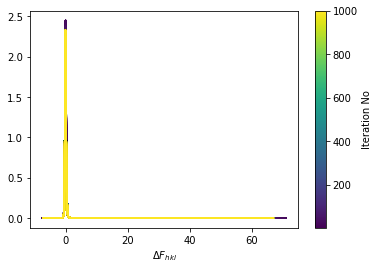

<Figure size 432x288 with 0 Axes>

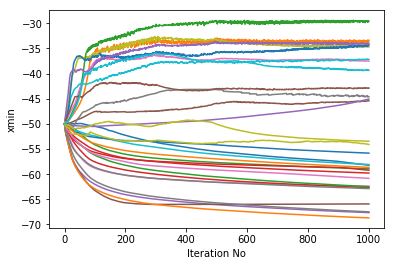

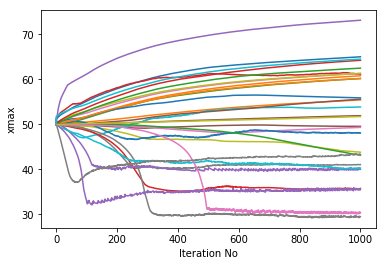

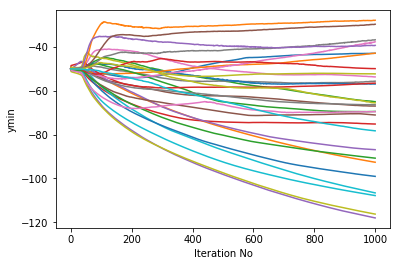

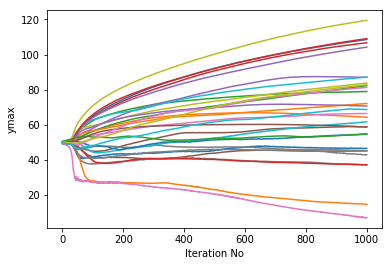

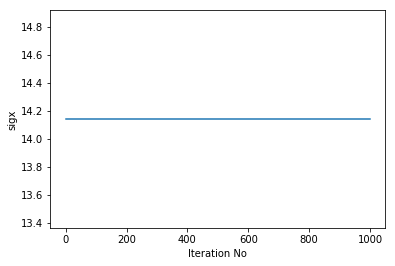

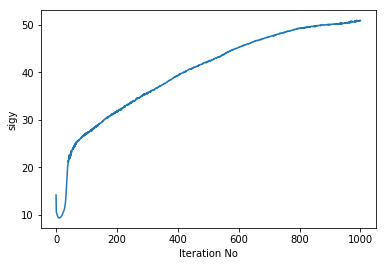

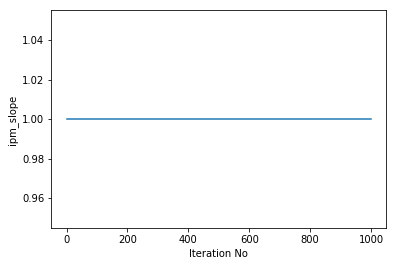

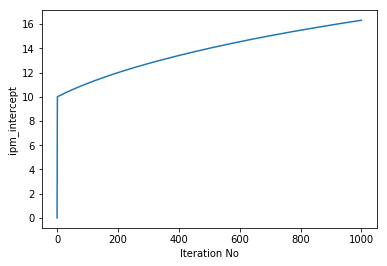

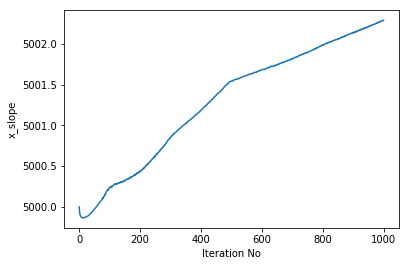

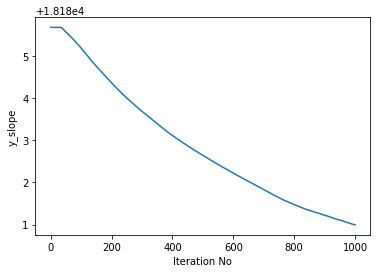

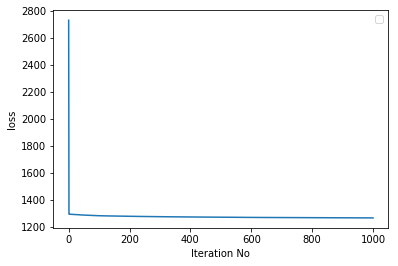

In [72]:
var_groups = {
    'IPM Slope'     : [ipm_slope, ipm_intercept],
    'Beam Shape'    : [sigx, sigy], 
    'Beam Position' : [x_slope, x_intercept, y_slope, y_intercept], 
    'Crystal Dimensions' : [xmin, xmax, ymin, ymax], 
}

#optimizers = {k:tf.train.AdagradOptimizer(1e-10).minimize(loss, var_list=v) for k,v in var_groups.items()}

#optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
optimizer = tf.train.AdagradOptimizer(10.).minimize(loss)

tf.gradients


nsteps = 1000
verbose=False
cmap = plt.get_cmap()
norm = plt.Normalize(vmin=1., vmax=nsteps)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array((1., nsteps))



logvars = {
    'xmin': xmin,
    'xmax': xmax,
    'ymin': ymin,
    'ymax': ymax,
    'sigx': sigx,
    'sigy': sigy,
    'Icryst': Icryst,
    'ipm_slope' : ipm_slope, 
    'x_slope' : x_slope, 
    'y_slope' : y_slope, 
    'gamma' : g,
    'deltaF unmerged': deltaF_unmerged,
    'deltaF' : deltaF,
    'ipm_intercept' : ipm_intercept, 
    'loss' : loss,
    #'regularizer' : regularizer,
    #'absolute_deviation' : absolute_deviation,
}

L = {k:[] for k in logvars}
#L['loss'] = []
deltaF_ = None
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for k,v in logvars.items():
        L[k].append(sess.run(v))
    print("0: {}".format(L['loss'][-1]))
    for i in range(nsteps):
        _,loss_ = sess.run((optimizer, loss))
        for k,v in logvars.items():
            L[k].append(sess.run(v))
        if np.isnan(L['loss'][-1]):
            break
        #print("{}: {}".format(i+1, L['loss'][-1]))
        if (i + 1) % 10 == 0:
            print("{}: {}".format(i+1, L['loss'][-1]))
        deltaF_ = sess.run(deltaF)
        x1, x2  = deltaF_.min(),deltaF_.max()
        X = np.linspace(x1 - 0.1*(x2 - x1), x2 + 0.1*(x2 - x1), 200)
        plt.plot(X, gaussian_kde(deltaF_)(X), c=sm.to_rgba(i+1))
        
        

plt.colorbar(sm, ax=plt.gca(), label='Iteration No')
plt.xlabel('$\Delta F_{hkl}$')

plotvars = ['xmin', 'xmax', 'ymin', 'ymax', 'sigx', 'sigy', 'ipm_slope', 'ipm_intercept', 'x_slope', 'y_slope', 'loss']

plt.figure()
for k in plotvars:
    v = L[k]
    plt.figure()
    plt.plot(v)
    plt.ylabel(k)
    plt.xlabel('Iteration No')
plt.legend()

Text(0,0.5,'$Crystal\\ \\hat X_{max}$')

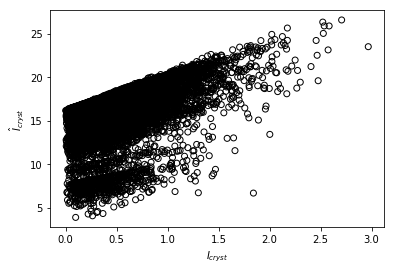

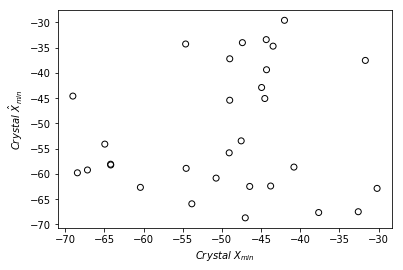

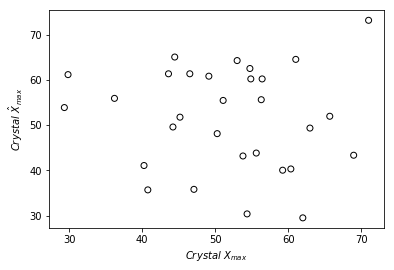

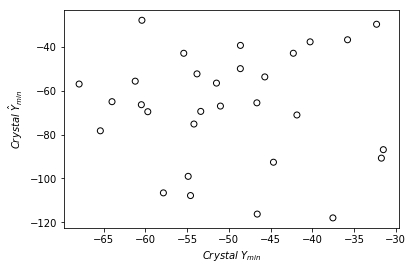

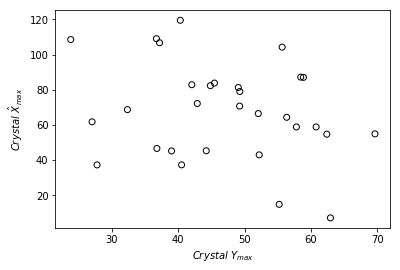

In [73]:
#How well is this doing at inferring parameters?
plt.scatter(I.groupby("IMAGEINDEX").mean()['Icryst'], L['Icryst'][-1], facecolors='none', edgecolors='k')
plt.xlabel(r"$I_{cryst}$")
plt.ylabel(r"$\hat I_{cryst}$")


plt.figure()
scatter(I.groupby("RUNINDEX").mean()['CRYSTLEFT'], L['xmin'][-1], facecolors='none', edgecolors='k')
plt.xlabel("$Crystal\ X_{min}$")
plt.ylabel("$Crystal\ \hat X_{min}$")

plt.figure()
scatter(I.groupby("RUNINDEX").mean()['CRYSTRIGHT'], L['xmax'][-1], facecolors='none', edgecolors='k')
plt.xlabel("$Crystal\ X_{max}$")
plt.ylabel("$Crystal\ \hat X_{max}$")

plt.figure()
scatter(I.groupby("RUNINDEX").mean()['CRYSTBOTTOM'], L['ymin'][-1], facecolors='none', edgecolors='k')
plt.xlabel("$Crystal\ Y_{min}$")
plt.ylabel("$Crystal\ \hat Y_{min}$")

plt.figure()
scatter(I.groupby("RUNINDEX").mean()['CRYSTTOP'], L['ymax'][-1], facecolors='none', edgecolors='k')
plt.xlabel("$Crystal\ Y_{max}$")
plt.ylabel("$Crystal\ \hat X_{max}$")

Text(0,0.5,'$Percent\\ Error$')

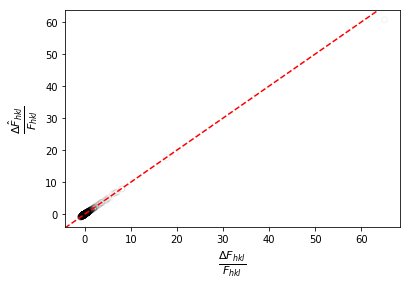

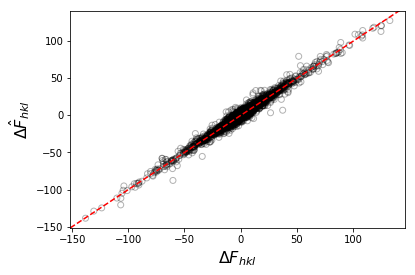

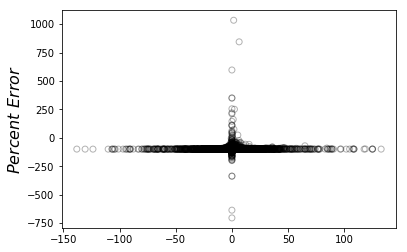

In [77]:
#deltaF_ = L['deltaF']
truegammas = np.array(I.groupby('GAMMAINDEX').mean()['gamma'])
trueFoff   = np.array(I.groupby('GAMMAINDEX').mean()['Foff'])
truedeltaF = trueFoff*(np.sqrt(truegammas) - 1)

deltaF_estimate = trueFoff*deltaF_

plt.scatter(truedeltaF/trueFoff, deltaF_, edgecolors='k', facecolors='none', alpha=0.05)
plt.xlabel(r'$\frac{\Delta F_{hkl}} {F_{hkl}}$', fontsize=16)
plt.ylabel(r'$\frac{\Delta \hat F_{hkl}} {F_{hkl}}$', fontsize=16)
xlim = plt.xlim()
ylim = plt.ylim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, x, '--r')
plt.xlim(xlim)
plt.ylim(ylim)

plt.figure()
plt.scatter(truedeltaF, deltaF_estimate, edgecolors='k', facecolors='none', alpha=0.3)
plt.xlabel(r'$\Delta F_{hkl} $', fontsize=16)
plt.ylabel(r'$\Delta \hat F_{hkl} $', fontsize=16)
xlim = plt.xlim()
ylim = plt.ylim()
x = np.linspace(xlim[0], xlim[1], 100)
plt.plot(x, x, '--r')
plt.xlim(xlim)
plt.ylim(ylim)

plt.figure()
x = np.sort(truedeltaF), 
y = (100.*(deltaF_estimate - truedeltaF)/truedeltaF)[np.argsort(truedeltaF)]
plt.scatter(np.sort(truedeltaF), (100.*(deltaF_ - truedeltaF)/truedeltaF)[np.argsort(truedeltaF)], color='k', facecolors='none', edgecolors='k', alpha=0.3)
plt.ylabel(r'$Percent\ Error$', fontsize=16)
#plt.ylim(-10, 10)

In [92]:
outFN = "test/deltaFestimate.hkl"
phaseFN = "test/1ubq.pdb.hkl"

from importlib import reload
import crystal
reload(crystal)

x = crystal.crystal().read_hkl(phaseFN)

H = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDH'], dtype=int)
K = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDK'], dtype=int)
L = np.array(I.groupby('GAMMAINDEX').mean()['MERGEDL'], dtype=int)

header = """{{ sg=P2(1)2(1)2(1) a=50.84 b=42.77 c=28.95 alpha=90 beta=90 gamma=90 }}
NREFlections={}
ANOMalous=FALSE
DECLare NAME=FOBS DOMAin=RECIprocal TYPE=COMPLEX END
""".format(len(deltaF_estimate))

with open(outFN, 'w') as out:
    out.write(header)
    for h,k,l,f in zip(H, K, L, deltaF_estimate):
        p = x.loc[h, k, l]['PHASE']
        out.write("INDE {} {} {} FOBS= {} {}\n".format(h,k,l,f,p))